# Loading processed data

In [29]:
# Importing data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

import optuna as o
from joblib import dump

# Importing processed data
X_train = pd.read_excel('D:/[01] SKILLS/[00] Projects/02 Probability of Default (PD) Model/data/processed/X_train.xlsx')
y_train = pd.read_excel('D:/[01] SKILLS/[00] Projects/02 Probability of Default (PD) Model/data/processed/y_train.xlsx')
X_test = pd.read_excel('D:/[01] SKILLS/[00] Projects/02 Probability of Default (PD) Model/data/processed/X_test.xlsx')
y_test = pd.read_excel('D:/[01] SKILLS/[00] Projects/02 Probability of Default (PD) Model/data/processed/y_test.xlsx')

## Handling Imbalance

In [30]:
# Using SMOTE Tomek to handle imbalance
smt = SMOTETomek()
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

# Model Development

In [31]:
models = {
    'Logistic Regression':LogisticRegression(),
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost':XGBClassifier()
}


for key, model in models.items():
    model.fit(X_train_smt, np.ravel(y_train_smt))
    y_pred = model.predict(X_test)
    print(f'Classification Report of {key}:')
    print(classification_report(y_test, y_pred))
    print("="*55)

Classification Report of Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     13714
           1       0.57      0.94      0.71      1285

    accuracy                           0.93     14999
   macro avg       0.78      0.94      0.84     14999
weighted avg       0.96      0.93      0.94     14999

Classification Report of SVC:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     13714
           1       0.61      0.94      0.74      1285

    accuracy                           0.94     14999
   macro avg       0.80      0.94      0.85     14999
weighted avg       0.96      0.94      0.95     14999

Classification Report of Decision Tree:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     13714
           1       0.62      0.76      0.69      1285

    accuracy                           0.94     14999
   macro avg

In such cases, we prefer high recall and therefore we will move ahead with `Logistic Regression`

## Optuna fine tuning 

In [32]:
# Defining the objective function to maximize
def objective(trial):
    C= trial.suggest_float('C', 1e-4, 1e4, log=True)
    solver= trial.suggest_categorical('solver', ['lbfgs', 'saga', 'liblinear', 'newton-cg'])

    model = LogisticRegression(
        C= C,
        solver= solver
    )

    f1_score = cross_val_score(
        estimator= model,
        X= X_train_smt, 
        y= np.ravel(y_train_smt),
        cv= 5,
        scoring= 'f1'
    ).mean()

    return f1_score

# Defining study
study = o.create_study(
     direction= 'maximize',
     sampler= o.samplers.TPESampler()
 )

study.optimize(func= objective, n_trials= 50)

[I 2025-08-24 16:21:30,844] A new study created in memory with name: no-name-cf8f014b-2cb6-4e73-9c0c-30fd50422345
[I 2025-08-24 16:21:31,619] Trial 0 finished with value: 0.9491599002946188 and parameters: {'C': 0.14876695749709945, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9491599002946188.
[I 2025-08-24 16:21:32,600] Trial 1 finished with value: 0.9420700810510191 and parameters: {'C': 0.05230217094560518, 'solver': 'liblinear'}. Best is trial 0 with value: 0.9491599002946188.
[I 2025-08-24 16:21:33,961] Trial 2 finished with value: 0.9522851029594284 and parameters: {'C': 2.6776929516857875, 'solver': 'saga'}. Best is trial 2 with value: 0.9522851029594284.
[I 2025-08-24 16:21:35,334] Trial 3 finished with value: 0.950930718371126 and parameters: {'C': 0.4627653082350223, 'solver': 'liblinear'}. Best is trial 2 with value: 0.9522851029594284.
[I 2025-08-24 16:21:36,153] Trial 4 finished with value: 0.9520527100155716 and parameters: {'C': 1.2843136486003506, 'solver': 'lbfgs

## Best parameters

In [33]:
print("Best Parameters:", study.best_trial.params)
print("F1 Score:", study.best_trial.value)

Best Parameters: {'C': 12.490728236643456, 'solver': 'newton-cg'}
F1 Score: 0.9525497338300815


## Best Model

In [34]:
model_lr_optuna = LogisticRegression(**study.best_trial.params)
model_lr_optuna.fit(X_train_smt, np.ravel(y_train_smt))
y_pred_lr_optuna = model_lr_optuna.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred_lr_optuna))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     13714
           1       0.58      0.94      0.71      1285

    accuracy                           0.94     14999
   macro avg       0.78      0.94      0.84     14999
weighted avg       0.96      0.94      0.94     14999



## ROC & AUC

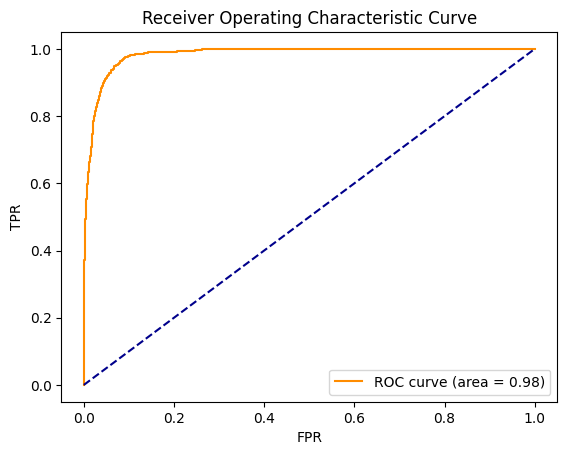

In [35]:
# Calculating probabilies for predictions
probabilities = model_lr_optuna.predict_proba(X_test)[:,1]

# Defining ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
area = auc(fpr,tpr)

plt.plot(
    fpr,
    tpr,
    color='darkorange',
    label=f'ROC curve (area = {area:.2f})' 
)
plt.plot(
    [0.0,1.0],
    [0.0,1.0],
    color='darkblue',
    linestyle='--'
)
plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

# Advance metrics

## Rank Ordering & KS Statistic

In [36]:
proxy= {
    'Default Truth': np.ravel(y_test),
    'Default Probability':probabilities,
    'Decile': pd.qcut(probabilities, q= 10, labels= False, duplicates= 'drop')

}

df_eval = pd.DataFrame(proxy)
df_eval.head()

,Default Truth,Default Probability,Decile
0,0,0.00271,6
1,0,0.00145,5
2,0,0.00000,2
3,0,0.07208,7
4,1,0.88904,9


In [37]:
pd.set_option('display.float_format', '{:.5f}'.format)

df_grp = df_eval.groupby('Decile').agg(
    Minimum_Probability=('Default Probability', 'min'),
    Maximum_Probability=('Default Probability', 'max'),
    Event=('Default Truth', 'sum'),
    Non_event=('Default Truth', lambda x: x.count() - x.sum())
).sort_values(by= 'Decile', ascending= False).reset_index()

df_grp['Event rate'] = (df_grp['Event'] / (df_grp['Event'] + df_grp['Non_event'])) * 100
df_grp['Non event rate'] = (df_grp['Non_event'] / (df_grp['Event'] + df_grp['Non_event'])) * 100

df_grp['Cum event'] = df_grp['Event'].cumsum()
df_grp['Cum Non event'] = df_grp['Non_event'].cumsum()

df_grp['Cum event rate'] = (df_grp['Cum event'] / df_grp['Event'].sum()) * 100
df_grp['Cum Non event rate'] = (df_grp['Cum Non event'] / df_grp['Non_event'].sum()) * 100

df_grp['KS'] = abs(df_grp['Cum event rate'] - df_grp['Cum Non event rate'])

df_grp

,Decile,Minimum_Probability,Maximum_Probability,Event,Non_event,Event rate,Non event rate,Cum event,Cum Non event,Cum event rate,Cum Non event rate,KS
0,9,0.80101,1.00000,1081,419,72.06667,27.93333,1081,419,84.12451,3.05527,81.06924
1,8,0.15746,0.80071,185,1315,12.33333,87.66667,1266,1734,98.52140,12.64401,85.87739
2,7,0.01824,0.15743,12,1488,0.80000,99.20000,1278,3222,99.45525,23.49424,75.96101
3,6,0.00229,0.01821,7,1493,0.46667,99.53333,1285,4715,100.00000,34.38092,65.61908
4,5,0.00034,0.00228,0,1499,0.00000,100.00000,1285,6214,100.00000,45.31136,54.68864
5,4,0.00006,0.00034,0,1500,0.00000,100.00000,1285,7714,100.00000,56.24909,43.75091
6,3,0.00001,0.00006,0,1500,0.00000,100.00000,1285,9214,100.00000,67.18682,32.81318
7,2,0.00000,0.00001,0,1500,0.00000,100.00000,1285,10714,100.00000,78.12454,21.87546
8,1,0.00000,0.00000,0,1500,0.00000,100.00000,1285,12214,100.00000,89.06227,10.93773
9,0,0.00000,0.00000,0,1500,0.00000,100.00000,1285,13714,100.00000,100.00000,0.00000


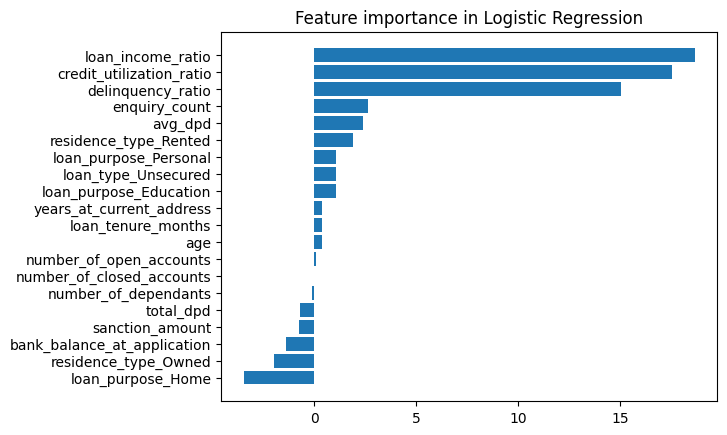

In [38]:
feature_imp_dict = {
    'Features': X_test.columns,
    'Coefficient': model_lr_optuna.coef_[0]
}
feature_imp_df = pd.DataFrame(feature_imp_dict).sort_values(by= 'Coefficient', ascending= True)
plt.barh(
    y= feature_imp_df['Features'],
    width= feature_imp_df['Coefficient']
)
plt.title('Feature importance in Logistic Regression')
plt.show()

## Gini Coefficient

In [39]:
gini = (area * 2) - 1
print(f"Gini Coefficient : {gini:.2f}")

Gini Coefficient : 0.97


# Exporting model

In [40]:
dump(
    value = model_lr_optuna,
    filename= 'D:/[01] SKILLS/[00] Projects/02 Probability of Default (PD) Model/model/model.joblib'
)

['D:/[01] SKILLS/[00] Projects/02 Probability of Default (PD) Model/model/model.joblib']